# Training Deep Networks

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Vanishing/Exploding Gradient Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


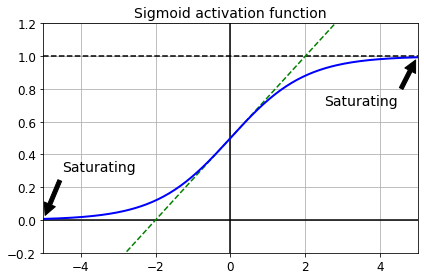

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), 'b-', linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Linear', xytext=(2, 0.2), xy=(50, 0.5), arrowprops=props, fontsize=14, ha='center')
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [4]:
[name for name in dir(keras.initializers) if not name.startswith('_')]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

If you want He initialization with a uniform distribution but based on *fan<sub>avg</sub>* rather than *fan<sub>in</sub>*, you can use the VarianceScaling initializer.

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                            distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions
### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


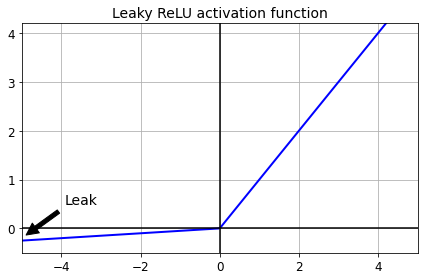

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0 # scale to 0 to 1
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(300, kernel_initializer="he_normal"),
  keras.layers.LeakyReLU(),
  keras.layers.Dense(100, kernel_initializer="he_normal"),
  keras.layers.LeakyReLU(),
  keras.layers.Dense(10, activation="softmax")
])

In [20]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
  import time
  run_id = time.strftime("run_%Y_%m_%d-%H_%M")
  return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [21]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4350 - accuracy: 0.8489 - val_loss: 0.4312 - val_accuracy: 0.8570
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4317 - accuracy: 0.8501 - val_loss: 0.4285 - val_accuracy: 0.8584
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4283 - accuracy: 0.8515 - val_loss: 0.4353 - val_accuracy: 0.8476
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4254 - accuracy: 0.8521 - val_loss: 0.4234 - val_accuracy: 0.8544
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4228 - accuracy: 0.8536 - val_loss: 0.4196 - val_accuracy: 0.8592
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4198 - accuracy: 0.8545 - val_loss: 0.4175 - val_accuracy: 0.8606
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4172 - accuracy: 0.8555 - val_loss: 0.4147 - val_accuracy:

Trying PReLU:

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(300, kernel_initializer="he_normal"),
  keras.layers.PReLU(),
  keras.layers.Dense(100, kernel_initializer="he_normal"),
  keras.layers.PReLU(),
  keras.layers.Dense(10, activation="softmax")
])

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [29]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [30]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4789 - accuracy: 0.8371 - val_loss: 0.4655 - val_accuracy: 0.8466
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4702 - accuracy: 0.8394 - val_loss: 0.4579 - val_accuracy: 0.8466
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4622 - accuracy: 0.8409 - val_loss: 0.4623 - val_accuracy: 0.8416
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4554 - accuracy: 0.8432 - val_loss: 0.4459 - val_accuracy: 0.8506
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4496 - accuracy: 0.8456 - val_loss: 0.4390 - val_accuracy: 0.8538
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4437 - accuracy: 0.8467 - val_loss: 0.4342 - val_accuracy: 0.8558
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4384 - accuracy: 0.8487 - val_loss: 0.4289 - val_accuracy:

## ELU - Exponential Linear Unit

In [33]:
def elu(z, alpha=1):
  return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


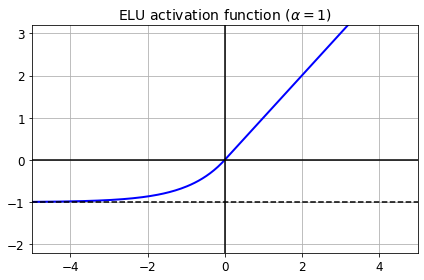

In [34]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

## SELU - Scaled Exponential Linear Uit

In [31]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [32]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [35]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
  return scale * elu(z, alpha)

Saving figure selu_plot


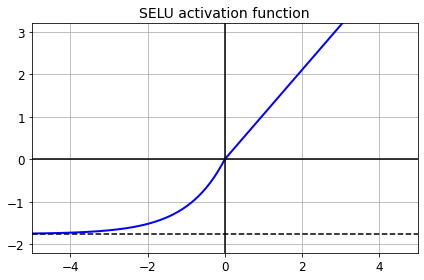

In [36]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters(`scale` and `alpha`) are tuned in such a way that mean coutput of each neuron remains close to 0, and the standard deviation remains close to 1(assuming inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [37]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
  W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100)) # LeCun initialization
  Z = selu(np.dot(Z, W))
  means = np.mean(Z, axis=0).mean()
  stds = np.std(Z, axis=0).mean()
  if layer % 100 == 0:
    print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU:

In [38]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

A neural net for Fashion MNIST with 100 hidden layers, using SELU activation function:

In [40]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                            kernel_initializer="lecun_normal"))
for layer in range(99):
  model.add(keras.layers.Dense(100, activation="selu",
                              kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [41]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation to 1:

In [42]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [43]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/5
1719/1719 [==============================] - 17s 9ms/step - loss: 1.0072 - accuracy: 0.6160 - val_loss: 0.7435 - val_accuracy: 0.7308
Epoch 2/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6563 - accuracy: 0.7611 - val_loss: 0.6534 - val_accuracy: 0.7768
Epoch 3/5
1719/1719 [==============================] - 15s 8ms/step - loss: 0.5596 - accuracy: 0.8027 - val_loss: 0.5267 - val_accuracy: 0.8174
Epoch 4/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4926 - accuracy: 0.8275 - val_loss: 0.4848 - val_accuracy: 0.8296
Epoch 5/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4584 - accuracy: 0.8393 - val_loss: 0.4627 - val_accuracy: 0.8446


What happens if we try to use the ReLU activation function instead:

In [44]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [46]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [47]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/5
1719/1719 [==============================] - 15s 7ms/step - loss: 2.0903 - accuracy: 0.2013 - val_loss: 1.6665 - val_accuracy: 0.3028
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.4697 - accuracy: 0.4255 - val_loss: 1.2872 - val_accuracy: 0.4808
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.3011 - accuracy: 0.4987 - val_loss: 1.0057 - val_accuracy: 0.6220
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9310 - accuracy: 0.6525 - val_loss: 0.7893 - val_accuracy: 0.7034
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9659 - accuracy: 0.6413 - val_loss: 1.1715 - val_accuracy: 0.5614


Accuracy became lower. We suffered from the vanishing/exploding gradients problem.